# Fit AdapIF to HH Spike Trains

In [1]:
from brian2 import *
from brian2modelfitting import *

import numpy as np

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
 [py.warnings]


In [2]:
dt = 0.01*ms
defaultclock.dt = dt

## Load the Data

In [3]:
voltage1 = genfromtxt('voltage1nA.csv', delimiter=',')
voltage2 = genfromtxt('voltage2nA.csv', delimiter=',')

In [4]:
inp_cur1 = genfromtxt('inp_cur1nA.csv', delimiter=',')
inp_cur2 = genfromtxt('inp_cur2nA.csv', delimiter=',')
inp_current = [inp_cur1, inp_cur2]
inp_current

[array([ 0.        , -0.01416314,  0.06263459, ..., -0.44478035,
        -0.39163954, -0.33014548]),
 array([ 0.        ,  0.39594954,  0.27878635, ..., -0.55344109,
        -0.71057181, -0.62256885])]

In [5]:
out_spikes1 = genfromtxt('out_spikes1nA.csv', delimiter=',')
out_spikes2 = genfromtxt('out_spikes2nA.csv', delimiter=',')
out_spikes = [out_spikes1, out_spikes2]
# out_spikes

## Model Fitting

In [6]:
# tau = 12.44*ms
# taut = 97.64*ms
# a = 0.21
# alpha = 7.2*mV
# R = 76*Mohm

model = '''
        dv/dt = (R*I- v)/tau : 1
        dvt/dt = (a*v - vt) / taut :1
        alpha : 1 (constant)
        a : 1 (constant)
        R : 1/amp (constant)
        tau : second (constant)
        taut : second (constant)
        D: second (constant)
        '''

reset = '''
v = 0
vt = vt + alpha
'''

In [7]:
set_device('cpp_standalone', directory='parallel2', clean=False)

In [8]:
n_opt = NevergradOptimizer()
metric = GammaFactor(time=50*second, delta=4*ms)

In [9]:
fitter = SpikeFitter(model=model, input_var='I', dt=dt,
                     input=inp_current * nA, output=out_spikes,
                     n_samples=20,
                     threshold='v > 1 + vt',
                     reset=reset,
                     refractory='D',
                     )

In [10]:
result_dict, error = fitter.fit(n_rounds=1,
                                optimizer=n_opt,
                                metric=metric,
                                callback='text',
                                alpha=[0.1, 10],
                                a = [0.1, 5],
                                R = [1, 100] * 1/nA, 
                                tau = [9, 50]*ms,
                                taut = [60, 120]*ms,
                                D = [0.5, 2]*ms,
                               )

Round 0: fit (0.022391944287472428, 7.967075061851385, 0.0014183685691907246, 54924588926.748055, 0.0687834998895738, 2.7012530872288836) with error: 0.06594970546005086


In [11]:
result_dict

{'tau': 0.022391944287472428,
 'alpha': 7.967075061851385,
 'D': 0.0014183685691907246,
 'R': 54924588926.748055,
 'taut': 0.0687834998895738,
 'a': 2.7012530872288836}

In [12]:
print('D', in_unit(result_dict['D']*second, ms))
print('a', 1.395984835969274)
print('tau', in_unit(result_dict['tau']*second, ms))
print('R', in_unit(result_dict['R']*ohm, Mohm))
print('taut', in_unit(result_dict['taut']*second, ms))
print('alpha', in_unit(result_dict['alpha']*volt, mV))

D 1.41836857 ms
a 1.395984835969274
tau 22.39194429 ms
R 54924.58892675 Mohm
taut 68.78349989 ms
alpha 7967.07506185 mV


In [13]:
error

0.06594970546005086

In [14]:
1 - error

0.9340502945399491

In [15]:
device.reinit()
device.activate()

In [16]:
# visualization of the results
spikes = fitter.generate_spikes(params=None)
# print('spike times:', spikes)

In [17]:
print(len(out_spikes[0]))
print(len(spikes[0]))

918
1033


In [18]:
print(len(out_spikes[1]))
print(len(spikes[1]))

1505
0


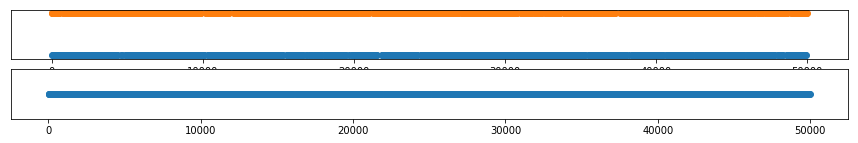

In [19]:
d=-1

fig, ax = plt.subplots(nrows=2, figsize=(15,2))

ax[0].set_yticks(np.arange(0, 1, step=1))
ax[0].scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
ax[0].scatter(spikes[0][:d], np.ones_like(spikes[0][:d])*2);

ax[1].set_yticks(np.arange(0, 1, step=1))
ax[1].scatter(out_spikes[1][:d], np.ones_like(out_spikes[1][:d]));
ax[1].scatter(spikes[1][:d], np.ones_like(spikes[1][:d])*2);

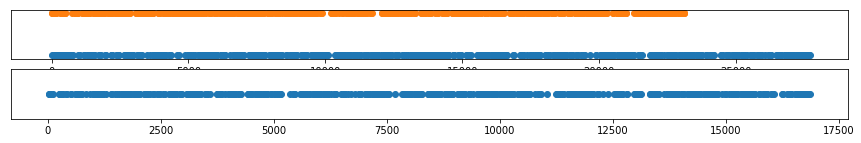

In [20]:
d=500


fig, ax = plt.subplots(nrows=2, figsize=(15,2))

ax[0].set_yticks(np.arange(0, 1, step=1))
ax[0].scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
ax[0].scatter(spikes[0][:d], np.ones_like(spikes[0][:d])*2);

ax[1].set_yticks(np.arange(0, 1, step=1))
ax[1].scatter(out_spikes[1][:d], np.ones_like(out_spikes[1][:d]));
ax[1].scatter(spikes[1][:d], np.ones_like(spikes[1][:d])*2);

In [21]:
device.reinit()
device.activate()

In [22]:
fits = fitter.generate(params=None, output_var='v',)

In [23]:
# fig, ax = plt.subplots(nrows=2, figsize=(15,10))

# ax[0].plot(voltage1);
# ax[0].plot(fits[0]/mV)

# ax[1].plot(voltage2);
# ax[1].plot(fits[1]/mV);


In [24]:
t0 = np.arange(0, len(voltage1)*dt, dt)
t_ = spikes[0]
t = spikes[0][t_<3000]

In [25]:
t

array([   6.23,   12.08,   73.16,   78.05,   84.97,  151.69,  177.62,
        292.04,  369.99,  414.57,  484.08,  485.49,  505.13,  759.83,
        850.65,  852.06,  899.81,  901.22,  928.33,  929.74,  967.17,
       1109.84, 1148.01, 1178.7 , 1264.45, 1276.55, 1316.58, 1420.4 ,
       1514.39, 1568.26, 1596.52, 1654.62, 1688.02, 1689.54, 1718.09,
       1816.3 , 1880.05, 1921.75, 1941.12, 2052.82, 2101.92, 2104.21,
       2170.75, 2173.64, 2179.56, 2219.54, 2307.33, 2335.74, 2342.72,
       2415.83, 2422.41, 2530.82, 2532.23, 2539.12, 2601.67, 2603.08,
       2644.18, 2647.04, 2681.07, 2686.2 , 2781.87, 2790.03, 2812.27,
       2857.68])

In [26]:
v = fits[0]
d = 300000

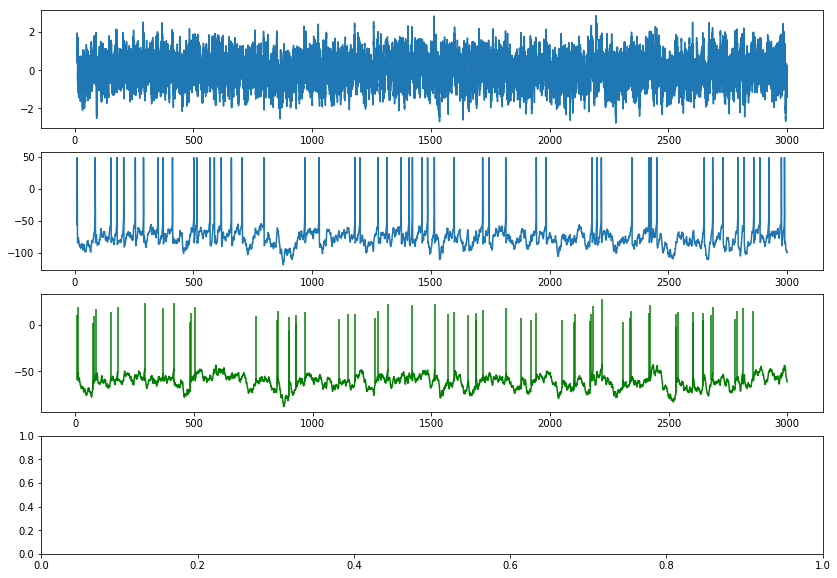

In [29]:
fig, ax = plt.subplots(nrows=4, figsize=(14,10))
ax[0].plot(t0[1000:d]/ms, inp_cur1[1000:d]);
ax[1].plot(t0[1000:d]/ms, voltage1[1000:d]);
ax[2].plot(t0[1000:d]/ms, v[1000:d]-60, 'g')
ax[2].vlines(t, v[np.int_(np.round(t/dt*ms))]+10, v[np.int_(np.round(t/dt*ms))]-60, 'g');

# ax[3].plot(t0[1000:d]/ms, voltage1[1000:d]);
# ax[3].plot(t0[1000:d]/ms, v[1000:d]/mV-60, 'r')
# ax[3].vlines(t, v[np.int_(np.round(t/dt*ms))]/mV+10, v[np.int_(np.round(t/dt*ms))]/mV-60, 'r');



In [ ]:
plt.figure(figsize=(10,5))
plot(t0[1000:d]/ms, v[1000:d]/mV-60, 'r')
vlines(t, v[np.int_(np.round(t/dt*ms))]/mV+60, v[np.int_(np.round(t/dt*ms))]/mV-60, 'r');
plot(t0[1000:d]/ms, voltage1[1000:d]);
